# Importing the Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import time 
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
from torchmetrics.classification import MulticlassF1Score,MulticlassRecall,MulticlassPrecision,MulticlassAccuracy,MulticlassConfusionMatrix

# Loading the Dataset

In [3]:
train_path = '/kaggle/input/tig-aluminium-5083/al5083/train/'
test_path = '/kaggle/input/tig-aluminium-5083/al5083/test/'

labels_ = {'0':'good weld',
          '1':'burn through',
          '2':'contamination',
          '3':'lack of fusion',
          '4':'misalignment',
          '5':'lack of penetration'}

In [4]:
# Loading the json files consisting of train and test image paths and labels

train_dict_ = json.load(open(train_path + 'train.json'))
test_dict_ = json.load(open(test_path + 'test.json'))

In [5]:
# Getting the image paths and labels in a list

def get_data_from_dict(data_dict_,ds):
    img_paths_ = list(data_dict_.keys())
    labels = list(data_dict_.values())
    print(f"No. of {ds} Images {len(img_paths_)}")
    return img_paths_,labels

In [6]:
train_img_paths,train_labels = get_data_from_dict(train_dict_,'train')
test_img_paths,test_labels = get_data_from_dict(test_dict_,'test')

No. of train Images 26666
No. of test Images 6588


In [7]:
# Displaying the image and printing the respective label with index

def plot_image(img_paths_,labels,random=True):
    if random:
        i = np.random.choice(len(img_paths_))
        print(i)
    key = img_paths_[i]
    label = str(labels[i])
    im_path = train_path + key.split('/')[-2] + '/' + key.split('/')[-1]
    img = cv2.imread(im_path)
    plt.imshow(img);
    print(labels_[label])

24893
lack of fusion


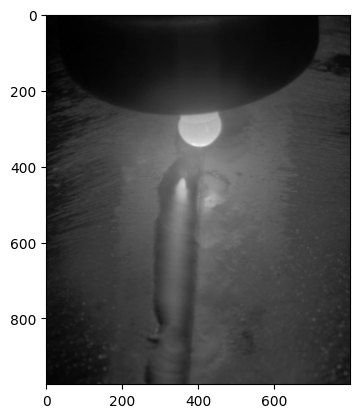

In [8]:
plot_image(train_img_paths,train_labels)

In [9]:
# Storing the image paths and labels in a pandas dataframe

def get_df(img_paths,labels):
    new_df = pd.DataFrame()
    new_df['Images'] = img_paths
    new_df['Labels'] = labels
    new_df.insert(2,'Label Names',[labels_[str(val)] for val in new_df['Labels']])
    
    return new_df

In [10]:
Train_df = get_df(train_img_paths,train_labels)
Test_df = get_df(test_img_paths,test_labels)

In [11]:
Train_df.Labels.value_counts()

Labels
0    8758
2    6325
3    4028
4    2953
5    2819
1    1783
Name: count, dtype: int64

# Plotting the Label counts

## Count of labels in Train dataset

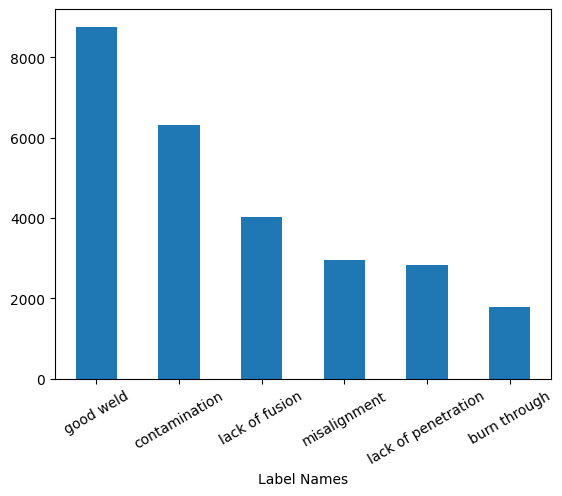

In [12]:
Train_df['Label Names'].value_counts().plot(kind='bar',rot=30);

## Count of labels in Test dataset

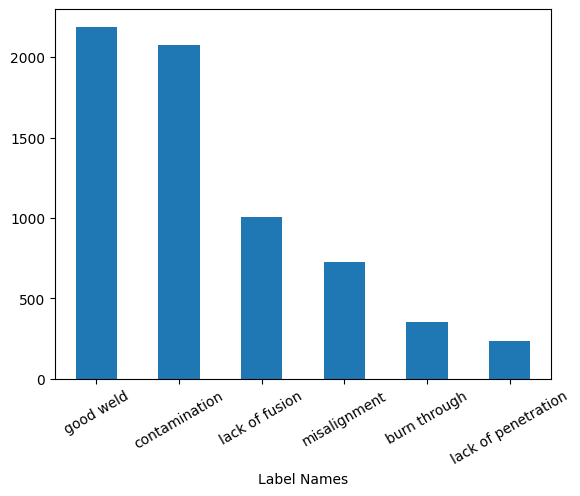

In [13]:
Test_df['Label Names'].value_counts().plot(kind='bar',rot=30);

In [14]:
Test_df['Label Names'].value_counts()

Label Names
good weld              2189
contamination          2078
lack of fusion         1007
misalignment            729
burn through            351
lack of penetration     234
Name: count, dtype: int64

In [15]:
labels_.values()

dict_values(['good weld', 'burn through', 'contamination', 'lack of fusion', 'misalignment', 'lack of penetration'])

# Balancing the Train and Test Labels

In [16]:
train_dfs_list = []
test_dfs_list = []

for lbl in labels_.values():
    if lbl == 'burn through':
        train_dfs_list.append(Train_df[Train_df['Label Names'] == lbl])
    else:
        train_dfs_list.append(Train_df[Train_df['Label Names'] == lbl].sample(2000))

for lbl in labels_.values():
    test_dfs_list.append(Test_df[Test_df['Label Names'] == lbl].sample(230))
        
train_df_final = pd.concat(train_dfs_list)
test_df_final = pd.concat(test_dfs_list)

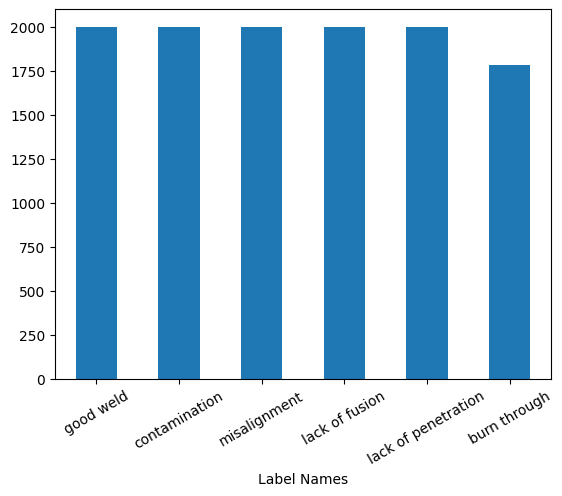

In [17]:
train_df_final['Label Names'].value_counts().plot(kind='bar',rot=30);

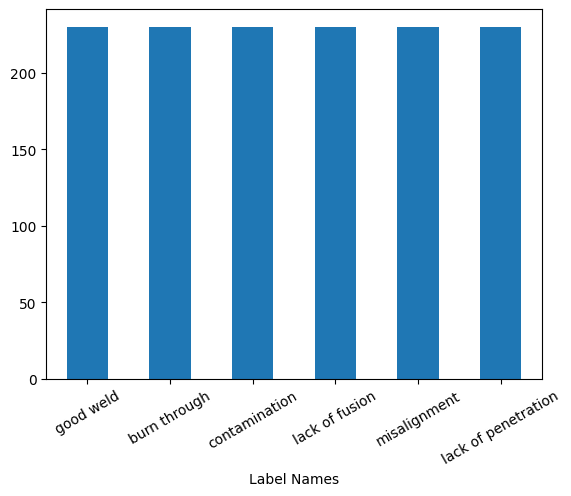

In [18]:
test_df_final['Label Names'].value_counts().plot(kind='bar',rot=30);

In [19]:
train_df_final.Images = train_path + train_df_final.Images
test_df_final.Images = test_path + test_df_final.Images

In [20]:
# Splitting the train and test set with 70-30 split

Total_df = pd.concat([train_df_final,test_df_final])

X = Total_df.drop('Labels',axis=1)
y = Total_df.Labels

X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,stratify=y,random_state=2529)

In [21]:
Train_dff = pd.concat([X_train,y_train],axis=1)
Test_dff = pd.concat([X_test,y_test],axis=1)

In [22]:
Train_dff#.Labels.value_counts()

,Images,Label Names,Labels
5175,/kaggle/input/tig-aluminium-5083/al5083/train/...,contamination,2
20602,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of penetration,5
26476,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of fusion,3
7152,/kaggle/input/tig-aluminium-5083/al5083/train/...,contamination,2
702,/kaggle/input/tig-aluminium-5083/al5083/train/...,burn through,1
...,...,...,...
22401,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of penetration,5
22482,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of penetration,5
16115,/kaggle/input/tig-aluminium-5083/al5083/train/...,good weld,0
23582,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of fusion,3


In [23]:
Test_dff

,Images,Label Names,Labels
12388,/kaggle/input/tig-aluminium-5083/al5083/train/...,good weld,0
226,/kaggle/input/tig-aluminium-5083/al5083/train/...,burn through,1
425,/kaggle/input/tig-aluminium-5083/al5083/train/...,burn through,1
25517,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of fusion,3
6577,/kaggle/input/tig-aluminium-5083/al5083/test/1...,lack of fusion,3
...,...,...,...
21365,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of penetration,5
6248,/kaggle/input/tig-aluminium-5083/al5083/train/...,contamination,2
3174,/kaggle/input/tig-aluminium-5083/al5083/train/...,contamination,2
22666,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of fusion,3


In [24]:
train_df_final = pd.concat([Train_dff,pd.get_dummies(Train_dff.Labels, dtype=int)],axis=1)
test_df_final = pd.concat([Test_dff,pd.get_dummies(Test_dff.Labels, dtype=int)],axis=1)

In [25]:
test_df_final.head()

,Images,Label Names,Labels,0,1,2,3,4,5
12388,/kaggle/input/tig-aluminium-5083/al5083/train/...,good weld,0,1,0,0,0,0,0
226,/kaggle/input/tig-aluminium-5083/al5083/train/...,burn through,1,0,1,0,0,0,0
425,/kaggle/input/tig-aluminium-5083/al5083/train/...,burn through,1,0,1,0,0,0,0
25517,/kaggle/input/tig-aluminium-5083/al5083/train/...,lack of fusion,3,0,0,0,1,0,0
6577,/kaggle/input/tig-aluminium-5083/al5083/test/1...,lack of fusion,3,0,0,0,1,0,0


In [26]:
def get_img_lbl(df,i=0,random=False):
    if random:
        i = np.random.choice(len(df))
        print(i)
    im_path = df.iloc[i].Images
    label = df.iloc[i].Labels
    img = cv2.imread(im_path)
    return img,label

# Define the Torch Dataset

In [27]:
class DataSet_gen(torch.utils.data.Dataset):
    def __init__(self,df):
        self.df = df

    def __getitem__(self,index):
        im_path = self.df.iloc[index].values[0]
        label = self.df.iloc[index].values[2]
        img = cv2.imread(im_path)
        img = cv2.resize(img, (256, 256))
        img = img.astype(np.float32)
        img = img/255.
        img = torch.from_numpy(img).permute(2, 0, 1)
        
        return img,label

    def __len__(self):
        return len(self.df)

In [28]:
trainset = DataSet_gen(train_df_final)
testset = DataSet_gen(test_df_final)

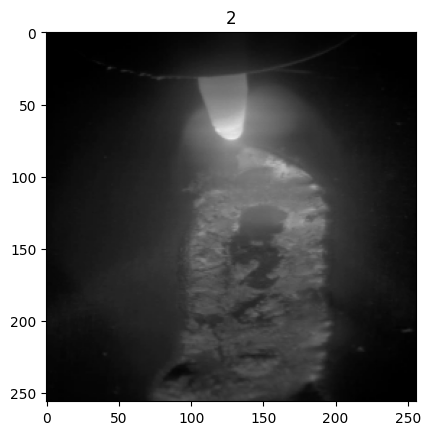

In [29]:
plt.imshow(trainset[0][0].permute(1,2,0));
plt.title(trainset[0][1])
plt.show()

In [30]:
# Defining the train and test loader that will be required for training and testing

train_loader = DataLoader(dataset=trainset,batch_size=64,shuffle=True)
test_loader = DataLoader(dataset=testset,batch_size=64,shuffle=False)

# Train and Test set size

In [31]:
len(trainset), len(testset)

(9214, 3949)

In [32]:
for images, labels in train_loader:
    break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([64, 3, 256, 256])
One batch label shape : torch.Size([64])


# Defining the CNN

In [33]:
class ImageModel(nn.Module):
    def __init__(self):
        super(ImageModel, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4,4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5,5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4,4), stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4,4), stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding=1),
            nn.ReLU(),
        )

        self.maxpool = nn.MaxPool2d(kernel_size=(4,4), stride=2)

        self.classifier = nn.Sequential(            
            nn.Flatten(),
            nn.Linear(9216,6400),
            nn.ReLU(),
            nn.Linear(6400,2048),
            nn.ReLU(),
            nn.Linear(2048,512),
            nn.ReLU(),
            nn.Linear(512,6)
        )

        self.gradient = None

    def activation_hook(self,grad): #get gradients
        self.gradient = grad

    def forward(self,images):
        x = self.feature_extractor(images) #activation_maps
        if x.requires_grad:
            h =  x.register_hook(self.activation_hook)
        x = self.maxpool(x)
        x = self.classifier(x)

        return x

    def get_activation_gradients(self): #a1,a2... (weights)
        return self.gradient

    def get_activation(self,x):
        return self.feature_extractor(x)

In [34]:
# Setting the device to cuda as we will be running our experiments on GPU

device = 'cuda'

model = ImageModel()
model.to(device)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=6400, bias=True)
    (2): ReLU()
    (3): Linear(in_features=6400, out_features=2048, bias=True)
    (4): Re

# Training function to train the model

In [35]:
def train_fn(dataloader,model,optimizer,criterion):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    for images,labels in tqdm(dataloader,colour='blue'):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits,labels)
        
        _, predicted = torch.max(logits, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    accuracy = 100 * total_correct / total_samples
    
    return total_loss / len(dataloader), accuracy

#  Eval function to test the model

In [36]:
def eval_fn(dataloader,model,criterion):
    model.eval()
    total_correct = 0
    total_loss = 0.0
    total_samples = 0
    
    for images,labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        loss = criterion(logits,labels)
        
        _, predicted = torch.max(logits, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        total_loss += loss.item()

    accuracy = 100 * total_correct / total_samples
    return total_loss / len(dataloader),accuracy

In [37]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

# Model Training

In [38]:
best_valid_loss = np.Inf
useful_stuff = {'training_loss':[],'training_accuracy':[],
                'testing_loss':[],'testing_accuracy':[]} 
# store starting time 
begin = time.time() 

for i in range(20):
    train_loss,train_acc = train_fn(train_loader,model,optimizer,criterion)
    test_loss,test_acc = eval_fn(test_loader,model,criterion)
    
    useful_stuff['training_loss'].append(train_loss)
    useful_stuff['training_accuracy'].append(train_acc)

    useful_stuff['testing_loss'].append(test_loss)
    useful_stuff['testing_accuracy'].append(test_acc)

    if test_loss < best_valid_loss:
        torch.save(model.state_dict(),'best_weights.pt')
        best_valid_loss = test_loss
        print("Weights savedd.")

    print(f'Epoch: {i+1} Train Loss: {train_loss} Train Accuracy: {train_acc} Test Loss: {test_loss} Test Accuracy: {test_acc}')

end = time.time()  

# total time taken
print(f"Total runtime of the CNN Model is {end - begin}") 

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 1 Train Loss: 0.8442648659563727 Train Accuracy: 66.42066420664207 Test Loss: 0.2851037745994906 Test Accuracy: 90.17472777918461


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 2 Train Loss: 0.19561496414502877 Train Accuracy: 93.43390492728457 Test Loss: 0.09897212452826 Test Accuracy: 96.73335021524437


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 3 Train Loss: 0.09315404901766063 Train Accuracy: 96.89602778380726 Test Loss: 0.04294314622435899 Test Accuracy: 98.78450240567233


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 4 Train Loss: 0.059101805310799845 Train Accuracy: 98.10071630128066 Test Loss: 0.03423582761353182 Test Accuracy: 98.80982527222082


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.044639796174629334 Train Accuracy: 98.71934013457782 Test Loss: 0.038876649210109346 Test Accuracy: 98.93643960496328


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 6 Train Loss: 0.05141622748528284 Train Accuracy: 98.5239852398524 Test Loss: 0.03410077899424059 Test Accuracy: 99.01240820460876


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.042643105469728146 Train Accuracy: 98.76275233340569 Test Loss: 0.06366777631093658 Test Accuracy: 98.12610787541149


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 8 Train Loss: 0.02168860086314655 Train Accuracy: 99.38137616670285 Test Loss: 0.023019400388640802 Test Accuracy: 99.44289693593315


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.04215266834014781 Train Accuracy: 98.78445843281962 Test Loss: 0.03288638779720772 Test Accuracy: 98.8604710053178


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 10 Train Loss: 0.021998344418130325 Train Accuracy: 99.41393531582375 Test Loss: 0.01122535503236577 Test Accuracy: 99.69612560141807


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.03286569457547254 Train Accuracy: 99.00151942695898 Test Loss: 0.08134422222933461 Test Accuracy: 97.18916181311724


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.05318928192314666 Train Accuracy: 98.5239852398524 Test Loss: 0.017385723530746727 Test Accuracy: 99.51886553557863


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Weights savedd.
Epoch: 13 Train Loss: 0.02951508925060706 Train Accuracy: 99.17516822227046 Test Loss: 0.00949829515130043 Test Accuracy: 99.6201570017726


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.03249950170277316 Train Accuracy: 98.97981332754505 Test Loss: 0.020836755307931117 Test Accuracy: 99.2149911369967


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.015816775533279624 Train Accuracy: 99.57673106142826 Test Loss: 0.0164850839078539 Test Accuracy: 99.36692833628767


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.00898325004695582 Train Accuracy: 99.73952680703277 Test Loss: 0.010215095958037343 Test Accuracy: 99.54418840212712


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.0463332480211294 Train Accuracy: 98.75189928369872 Test Loss: 0.0926653227708753 Test Accuracy: 96.65738161559888


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.02702955405215511 Train Accuracy: 99.16431517256349 Test Loss: 0.02640432564751996 Test Accuracy: 99.13902253735122


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.010618491200988147 Train Accuracy: 99.71782070761884 Test Loss: 0.012299551369529406 Test Accuracy: 99.6201570017726


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.009351283459636761 Train Accuracy: 99.70696765791187 Test Loss: 0.011564851838380902 Test Accuracy: 99.72144846796657
Total runtime of the CNN Model is 3301.284468650818


# Model Loss

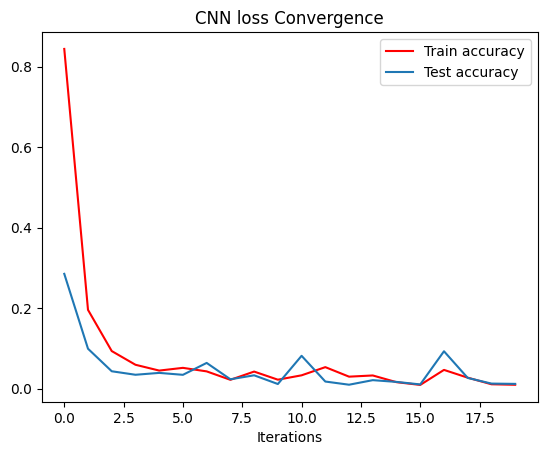

In [40]:
# Plot loss convergence

plt.plot(useful_stuff['training_loss'],'r')
plt.plot(useful_stuff['testing_loss'])
plt.title("CNN loss Convergence")
plt.legend(["Train accuracy", "Test accuracy"], loc="upper right")
plt.xlabel("Iterations")
plt.show()

# Model accuracy

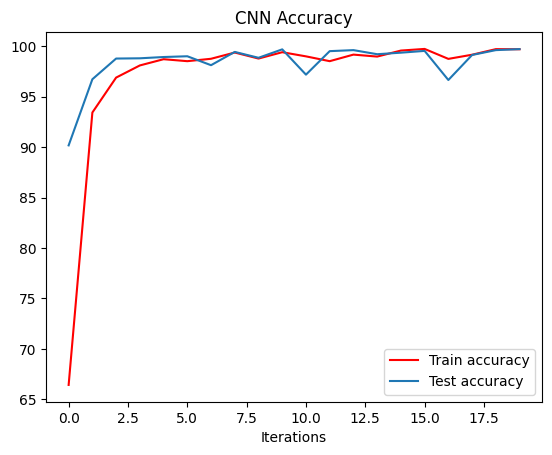

In [41]:
# Plot loss convergence
plt.plot(useful_stuff['training_accuracy'],'r')
plt.plot(useful_stuff['testing_accuracy'])
plt.title("CNN Accuracy")
plt.xlabel("Iterations")
plt.legend(["Train accuracy", "Test accuracy"], loc="lower right")
plt.show()

**Gradient-weighted Class Activation Mapping
(Grad-CAM), uses the gradients of any target concept (say
‘dog’ in a classification network or a sequence of words
in captioning network) flowing into the final convolutional
layer to produce a coarse localization map highlighting the
important regions in the image for predicting the concept.**

In [73]:
def get_GradCam(model,image,label,size):
    label.backward()
    gradients = model.get_activation_gradients() #weights
    pooled_grads = torch.mean(gradients,dim=[0,2,3])
    activations = model.get_activation(image).detach() #get activation map
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_grads[i]

    heatmap = torch.mean(activations,dim=1).squeeze().cpu()
    heatmap = nn.ReLU()(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(),(size,size))
    return heatmap

# Plot the heatmap on Image to see what regions has the model learned

In [75]:
def plot_heatmap(denorm_image, label,pred, heatmap):

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20,20), ncols=3)

    classes = list(labels_.values())
    ps = torch.nn.Softmax(dim = 1)(pred).cpu().detach().numpy()
    ax1.imshow(denorm_image)
    ax1.set_title(classes[label],color='green')
    ax2.barh(classes, ps[0])
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    ax3.imshow(denorm_image)
    ax3.imshow(heatmap, cmap='magma', alpha=0.7)

# Let's see what the model learned using GradCam

In [76]:
list(labels_.values())

['good weld',
 'burn through',
 'contamination',
 'lack of fusion',
 'misalignment',
 'lack of penetration']

# Lets understand the Model's Learning with the help of grad-CAM

## Example 1

(256, 256)


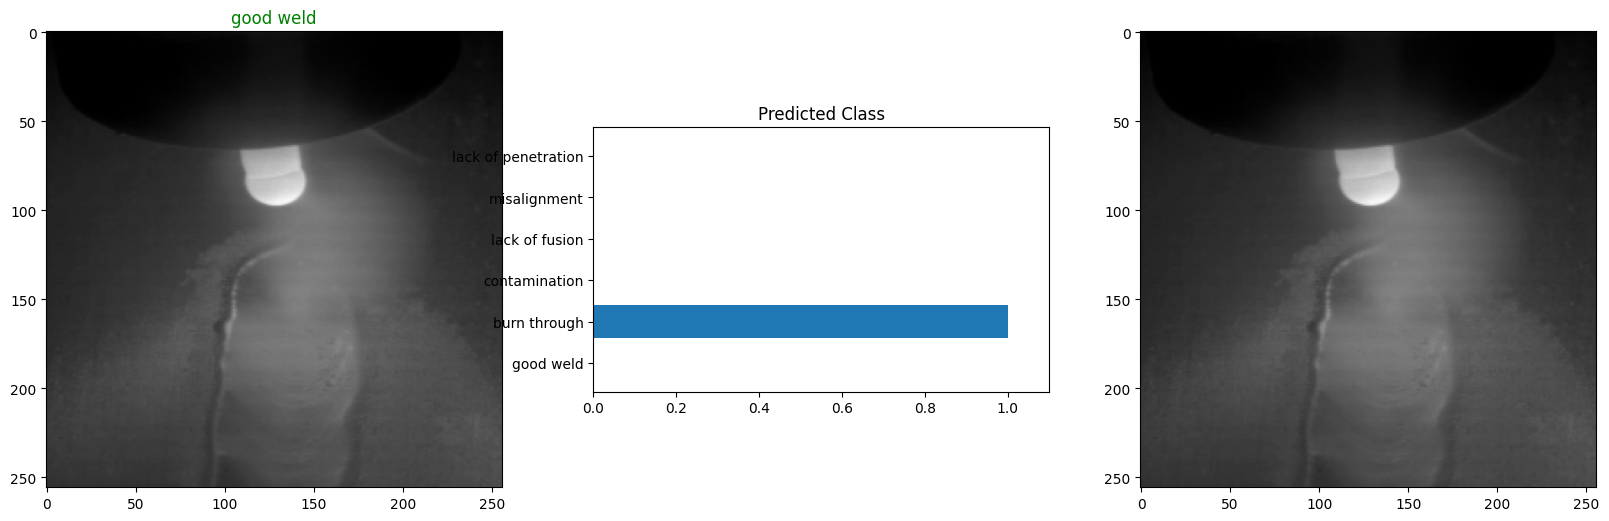

In [80]:
# 0 -> good weld'; 1-> 'burn through';  2-> 'contamination', 
# 3-> 'lack of fusion'; 4-> 'misalignment' 5-> 'lack of penetration'

image,label = testset[0] 

denorm_image = image.permute(1,2,0) 

image = image.unsqueeze(0)#.to(device)
image = image.to(device) #* 255.
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][0],size=256)
plot_heatmap(denorm_image,label,pred,heatmap) #* 255.)

## Example 2

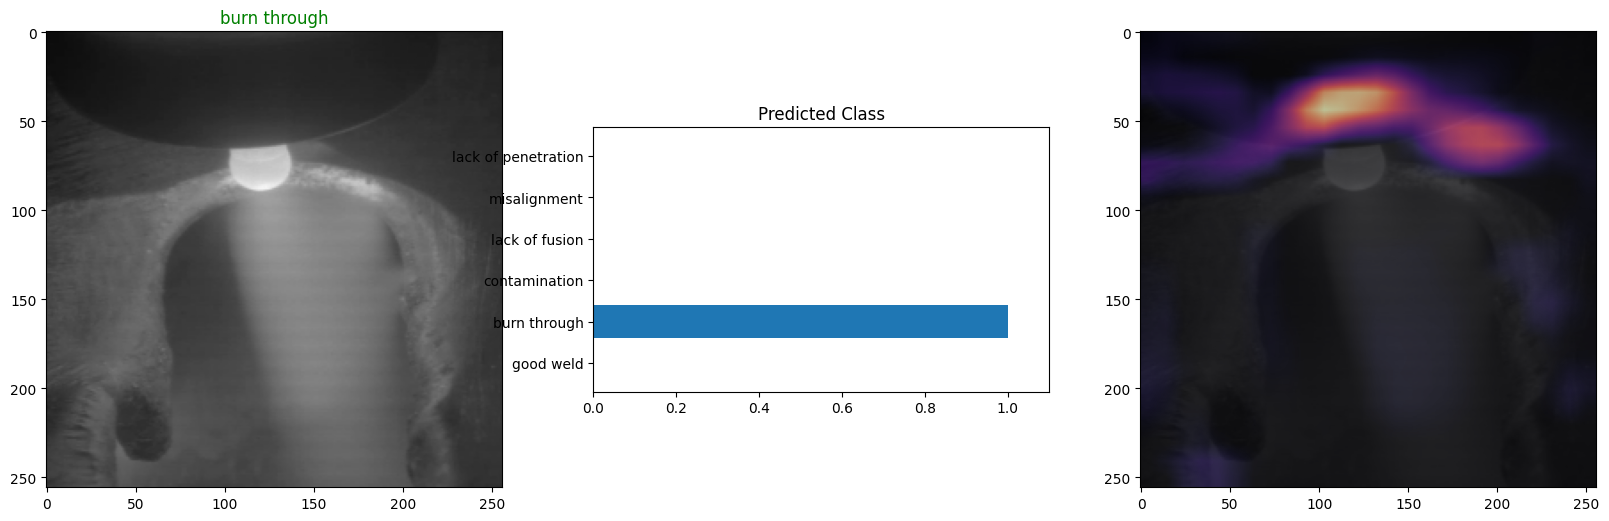

In [64]:
# 0 -> good weld'; 1-> 'burn through';  2-> 'contamination', 
# 3-> 'lack of fusion'; 4-> 'misalignment' 5-> 'lack of penetration'


image,label = testset[1]

denorm_image = image.permute(1,2,0)

image = image.unsqueeze(0)#.to(device)
image = image.to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][1],size=256)
plot_heatmap(denorm_image,label,pred,heatmap)

## Example 3

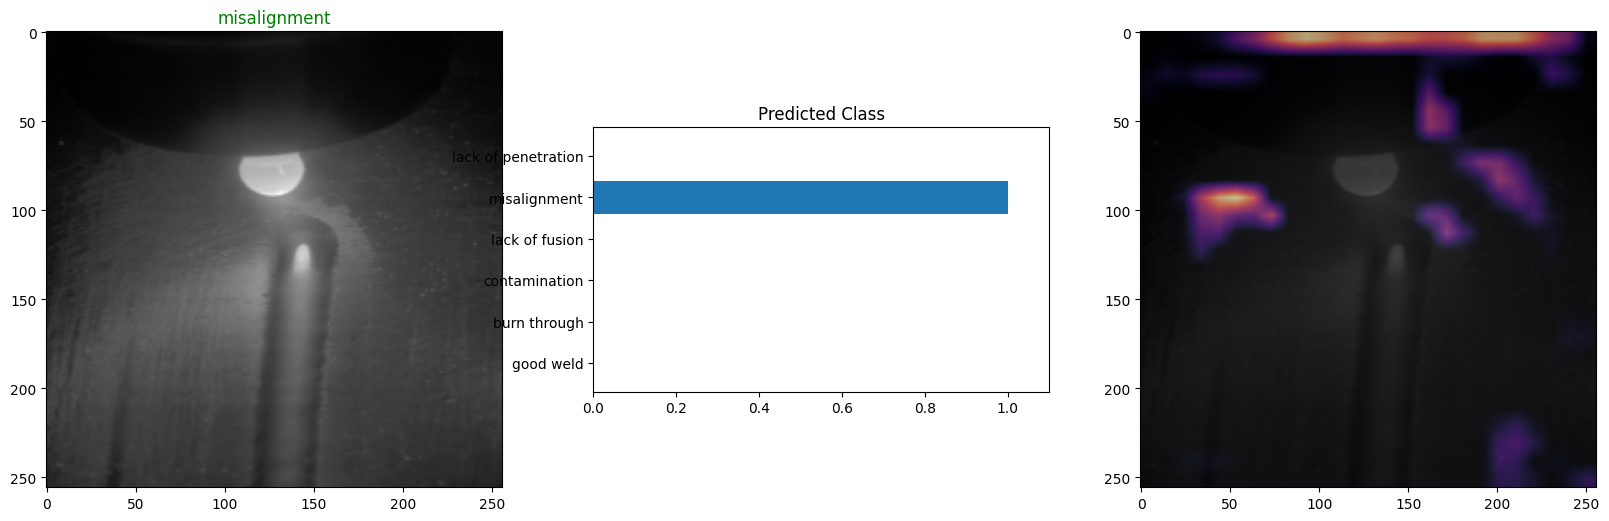

In [59]:
# 0 -> good weld'; 1-> 'burn through';  2-> 'contamination', 
# 3-> 'lack of fusion'; 4-> 'misalignment' 5-> 'lack of penetration'

image,label = testset[10]

denorm_image = image.permute(1,2,0) 

image = image.unsqueeze(0).to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][4],size=256)
plot_heatmap(denorm_image,label,pred,heatmap)

## Example 4

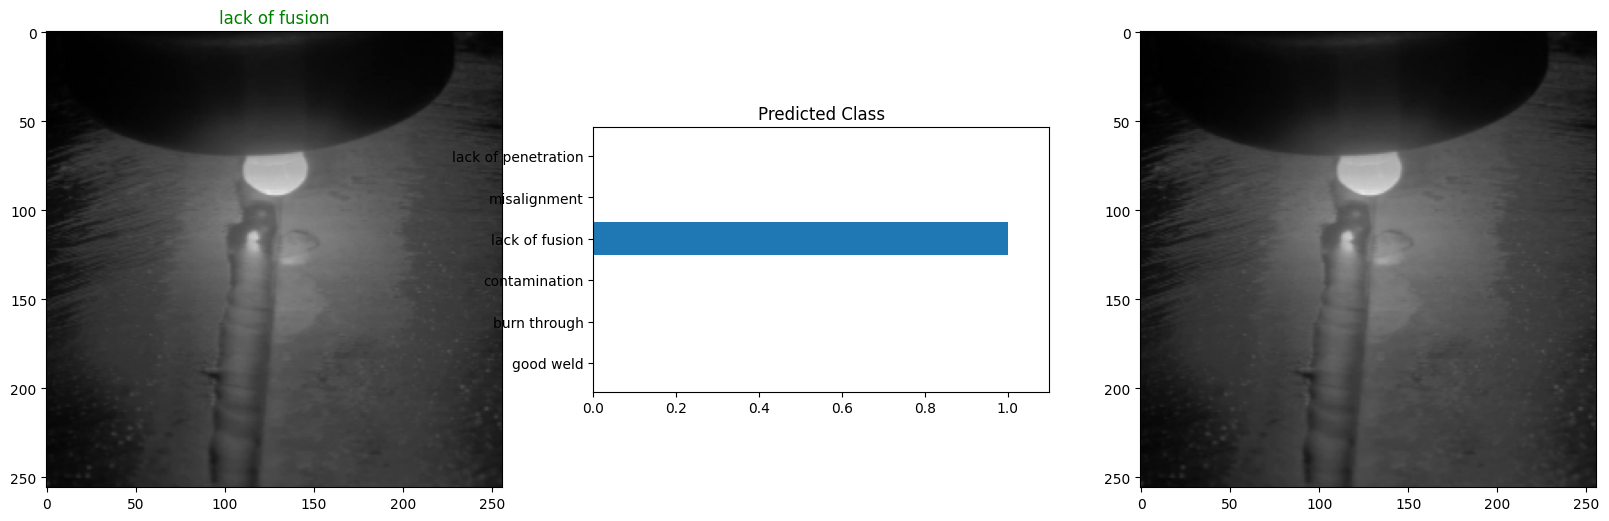

In [60]:
# 0 -> good weld'; 1-> 'burn through';  2-> 'contamination', 
# 3-> 'lack of fusion'; 4-> 'misalignment' 5-> 'lack of penetration'

image,label = testset[3]

denorm_image = image.permute(1,2,0) 

image = image.unsqueeze(0).to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][3],size=256)
plot_heatmap(denorm_image,label,pred,heatmap)

## Example 5

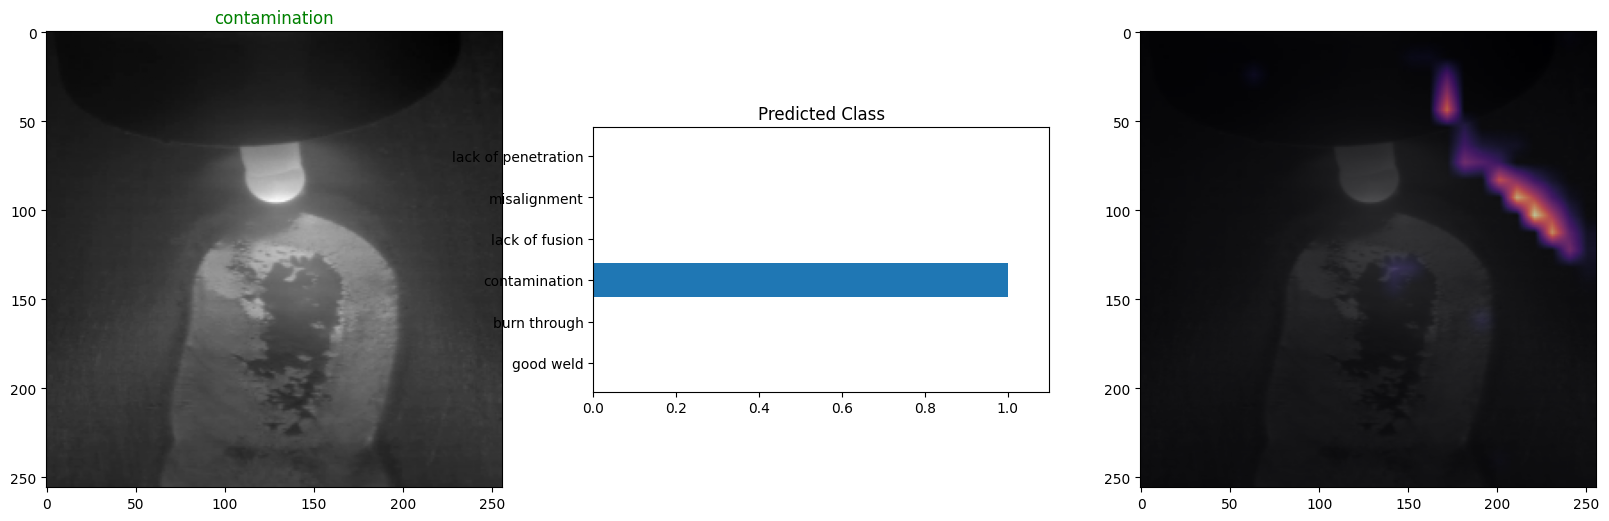

In [61]:
# 0 -> good weld'; 1-> 'burn through';  2-> 'contamination', 
# 3-> 'lack of fusion'; 4-> 'misalignment' 5-> 'lack of penetration'

image,label = testset[5]

denorm_image = image.permute(1,2,0) 

image = image.unsqueeze(0).to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][2],size=256)
plot_heatmap(denorm_image,label,pred,heatmap)

## Example 6

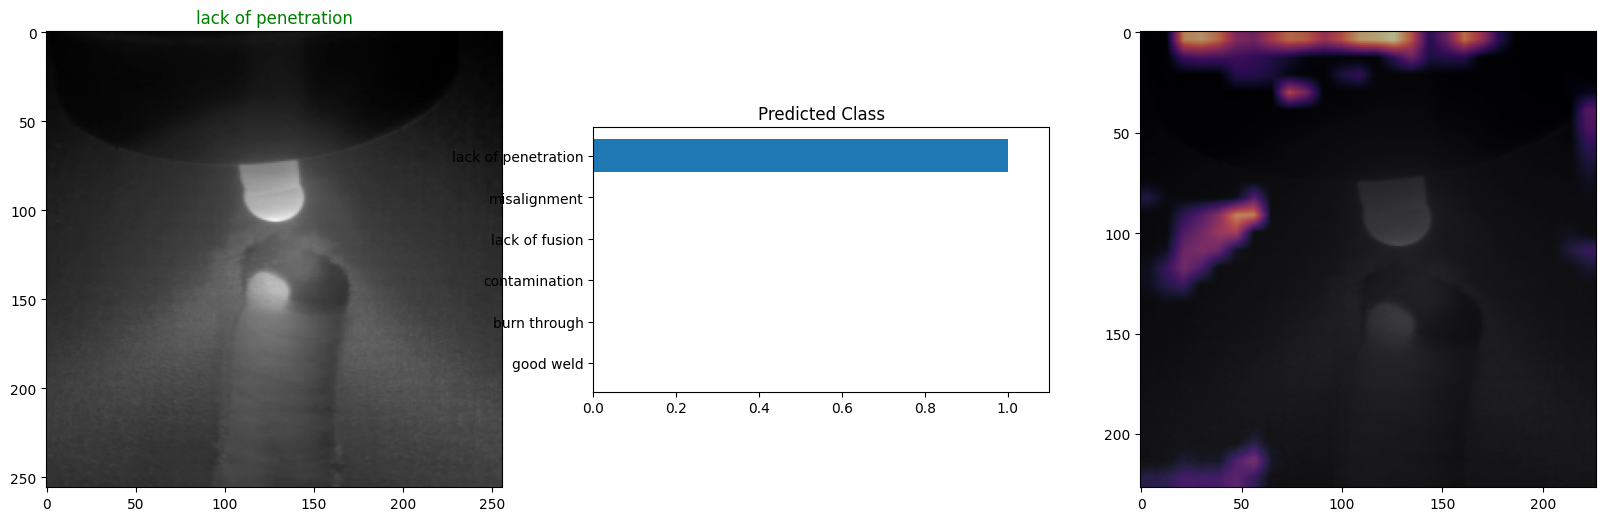

In [62]:
# 0 -> good weld'; 1-> 'burn through';  2-> 'contamination', 
# 3-> 'lack of fusion'; 4-> 'misalignment' 5-> 'lack of penetration'

image,label = testset[100]

denorm_image = image.permute(1,2,0) 

image = image.unsqueeze(0).to(device)
pred = model(image)
heatmap = get_GradCam(model,image,pred[0][5],size=227)
plot_heatmap(denorm_image,label,pred,heatmap)

# Analyzing the results acheived with Gradcam

**Example 1:** The model is able to classify the image and correctly predict the label which is `good weld` but still we cannot see the heatmap on the resulting image. **which means that the CNN failed to capture any relevant features.**

**Example 2 :** The model is also able to classify this example and correctly predict the label which is `burn through` here some parts of the heatmaps are visible but it is still not enough as the **region captured is not the region of interest** so the CNN has again failed to capture the relevant features.

**Example 3:** The model is also able to classify this example correctly predict the label which is `misalignment` here the **heatmap shown is highlighting some part of the region of interest which still is not sufficient but better than the first two examples**.

**Example 4:** The model is able to classify the image and correctly predict the label which is `lack of fusion` but still we cannot see the heatmap on the resulting image. **which means that the CNN has failed to capture any relevant features.**

**Example 5:** The model is able to classify the image and correctly predict the label which is `contamination` but still we cannot see the heatmap on the region of interest. The results shown here is not helpful as the **CNN failes to capture the region of interest.**

**Example 6:** The model is able to classify the image and correctly predict the label which is `lack of penetration` but still we cannot see the heatmap on the resulting image. **which means that the CNN has failed to capture any relevant features.**


The analysis from these examples tells us that model being able to classify the images with 99% accuracy for training and testing but still failed to capture the relevant features and highlight the regions of interest in 5 out of 6 images.

In [52]:
# model2 = ImageModel()
# model2.load_state_dict(torch.load('/kaggle/working/best_weights.pt'))
# model2.to(device)
# model2.eval()

In [53]:
def check_accuracy(loader, model):
        num_correct = 0
        num_samples = 0
        preds = []
        y_true = []
        model.eval()

        with torch.no_grad():
            for x, y in loader:
                x = x.to(device)
                y = y.to(device)
                scores = model(x)
                _, predictions = scores.max(1)
                num_correct += (predictions == y.squeeze()).sum()
                num_samples += predictions.size(0)
                
                preds.append(scores.to('cpu'))
                y_true.append(y.to('cpu'))
                
            acc = float(num_correct)/float(num_samples)*100
            print(f'Got {num_correct} / {num_samples} with accuracy {acc:.2f}')
        
        model.train()
        
        metrica = MulticlassAccuracy(num_classes=6)
        metricp = MulticlassPrecision(num_classes=6)
        metricr = MulticlassRecall(num_classes=6)
        metricf = MulticlassF1Score(num_classes=6)
        
        metricat = MulticlassAccuracy(num_classes=6,average=None)
        metricpt = MulticlassPrecision(num_classes=6,average=None)
        metricrt = MulticlassRecall(num_classes=6,average=None)
        metricft = MulticlassF1Score(num_classes=6,average=None)
        
        print('Total Accuracy :', metrica(torch.cat(preds), torch.cat(y_true)).item() * 100)
        print('Total Precision :', metricp(torch.cat(preds), torch.cat(y_true)).item() * 100)
        print('Total Recall :', metricr(torch.cat(preds), torch.cat(y_true)).item() * 100)
        print('Total F1-score :', metricf(torch.cat(preds), torch.cat(y_true)).item() * 100)
        print()
        print('Accuracy for Each Classes:', metricat(torch.cat(preds), torch.cat(y_true)) * 100)
        print('Precision for Each Classes:', metricpt(torch.cat(preds), torch.cat(y_true)) * 100)
        print('Recall for Each Classes:', metricrt(torch.cat(preds), torch.cat(y_true)) * 100)
        print('F1-score for Each Classes:', metricft(torch.cat(preds), torch.cat(y_true)) * 100) 

# Results

In [55]:
check_accuracy(test_loader,model)

Got 3938 / 3949 with accuracy 99.72
Total Accuracy : 99.72596168518066
Total Precision : 99.72422122955322
Total Recall : 99.72596168518066
Total F1-score : 99.72467422485352

Accuracy for Each Classes: tensor([ 99.8505, 100.0000,  99.4021, 100.0000,  99.7010,  99.4021])
Precision for Each Classes: tensor([ 99.4048,  99.8347, 100.0000, 100.0000,  99.2560,  99.8499])
Recall for Each Classes: tensor([ 99.8505, 100.0000,  99.4021, 100.0000,  99.7010,  99.4021])
F1-score for Each Classes: tensor([ 99.6271,  99.9173,  99.7001, 100.0000,  99.4780,  99.6255])


In [56]:
import pickle as pkl
with open('/kaggle/working/CNN_results.pkl','wb') as f:
    pkl.dump(useful_stuff,f)

In [57]:
def plot_CM(loader, model):
        num_correct = 0
        num_samples = 0
        preds = []
        y_true = []
        model.eval()

        with torch.no_grad():
            for x, y in loader:
                x = x.to(device)
                y = y.to(device)
                scores = model(x)
                _, predictions = scores.max(1)
                num_correct += (predictions == y.squeeze()).sum()
                num_samples += predictions.size(0)
                
                preds.append(scores.to('cpu'))
                y_true.append(y.to('cpu'))
                
            acc = float(num_correct)/float(num_samples)*100
            print(f'Got {num_correct} / {num_samples} with accuracy {acc:.2f}')
        
        metric = MulticlassConfusionMatrix(num_classes=6)
        metric.update(torch.cat(preds), torch.cat(y_true))
        fig_, ax_ = metric.plot()
        
        model.train()

Got 3938 / 3949 with accuracy 99.72


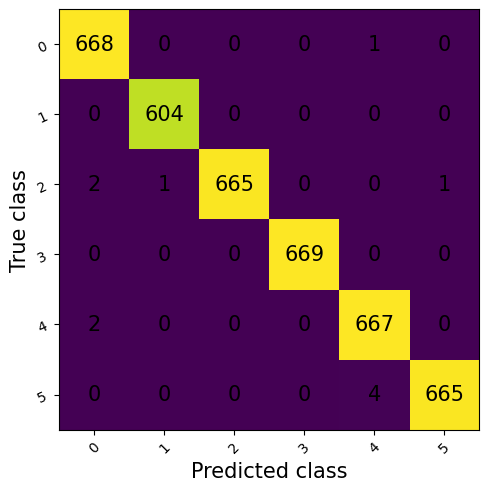

In [58]:
 plot_CM(test_loader, model)